# Imputing Ecological Momentary Assessment (EMA) data

In [25]:
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from missingness_utils import produce_NA
from jmspack.frequentist_statistics import correlation_analysis
from jmspack.utils import JmsColors

In [2]:
from jmspack.utils import flatten, apply_scaling
from sklearn.metrics import mean_squared_error

In [3]:
import miceforest as mf
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [9]:
csv_list = glob("../../datasets/example_ema_data/UT1000_spring2019/*/*/daily_emas*.csv")

df_long = (pd.concat([pd.read_csv(x, index_col=[0]) for x in csv_list])
           .assign(**{"date": lambda d: pd.to_datetime(d["survey.date"])}))

df_wide = df_long.pivot_table(index=["pid", "date"], columns="variable")
df_wide.columns=df_wide.columns.get_level_values(level=1)

In [10]:
display(df_wide.head()); display(df_long.head()); df_long.info()

variable             content  energy  lonely  refreshed  restful  sad  sleep  \
pid      date                                                                  
1193rv5x 2019-02-14      3.0     3.0     2.0        2.0      3.0  1.0    5.0   
         2019-02-15      2.0     3.0     3.0        1.0      2.0  2.0    6.0   
         2019-02-16      1.0     2.0     3.0        1.0      2.0  2.0    9.0   
         2019-02-17      1.0     1.0     3.0        2.0      2.0  3.0    9.0   
         2019-02-18      3.0     3.0     1.0        1.0      2.0  1.0    5.0   

variable             stress  
pid      date                
1193rv5x 2019-02-14     1.0  
         2019-02-15     1.0  
         2019-02-16     1.0  
         2019-02-17     2.0  
         2019-02-18     1.0

,pid,survey.date,local.time,answer,variable,date
1,cpz816fe,2019-02-16,2019-02-16 21:25:34,1,sad,2019-02-16
2,cpz816fe,2019-02-17,2019-02-17 21:23:29,2,sad,2019-02-17
3,cpz816fe,2019-02-18,2019-02-18 21:03:21,1,sad,2019-02-18
4,cpz816fe,2019-02-19,2019-02-19 21:01:08,1,sad,2019-02-19
5,cpz816fe,2019-02-21,2019-02-21 21:15:41,1,sad,2019-02-21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 55791 entries, 1 to 139
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pid          55791 non-null  object        
 1   survey.date  55791 non-null  object        
 2   local.time   55791 non-null  object        
 3   answer       55791 non-null  int64         
 4   variable     55791 non-null  object        
 5   date         55791 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.0+ MB


In [11]:
# _ = plt.figure(figsize=(20, 5))
# _ = sns.lineplot(data=df_long, x="date", y="answer", hue="variable")
# _ = sns.scatterplot(data=df_long, x="date", y="answer", hue="variable")

In [12]:
# df_wide.apply(lambda d: d.value_counts())

In [13]:
feature = "sleep"
df=df_wide[[feature]].dropna().reset_index()
df.columns.name = None

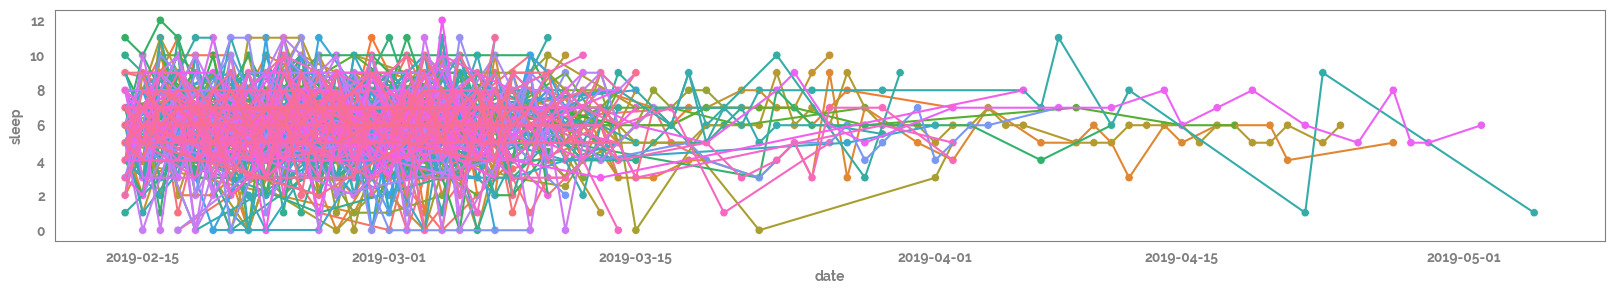

In [14]:
_ = plt.figure(figsize=(20,3))
_ = sns.lineplot(data=df,
                 x="date",
                 y=feature,
                 hue="pid",
                 legend=False)
_ = sns.scatterplot(data=df,
                 x="date",
                 y=feature,
                 hue="pid",
                 legend=False)
# _ = plt.xlim("2019-02-15", "2019-03-15")

In [15]:
user_counts_df = df[df["date"].isin(pd.date_range("2019-02-15", "2019-03-15"))].groupby("pid").count().sort_values(by="date")[[feature]]
user_ids = user_counts_df[user_counts_df[feature]==29].index.tolist()

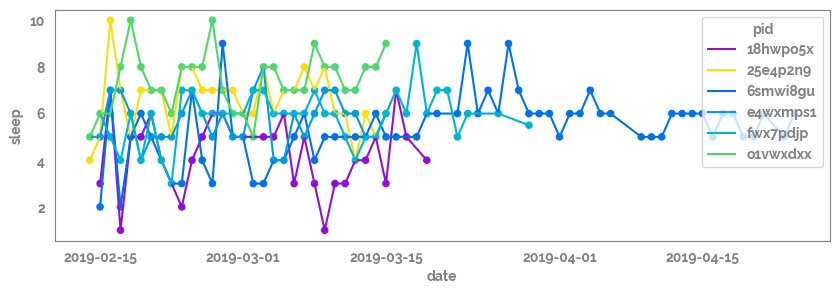

In [16]:
_ = plt.figure(figsize=(10,3))
_ = sns.lineplot(data=df[df["pid"].isin(user_ids)],
                 x="date",
                 y=feature,
                 hue="pid",
                 legend=True)
_ = sns.scatterplot(data=df[df["pid"].isin(user_ids)],
                 x="date",
                 y=feature,
                 hue="pid",
                 legend=False)
# _ = plt.xlim("2019-02-15", "2019-03-15")

In [17]:
# Sample mnar data with logistic model -----------------------------------------
X_miss_mnar = produce_NA(df[[feature]].to_numpy(), p_miss=0.6, mecha="MNAR", opt="logistic", p_obs=0.5)

X_mnar = X_miss_mnar['X_incomp']
R_mnar = X_miss_mnar['mask']

print("Percentage of generated missing values: ", (R_mnar.sum()).numpy()/np.prod(R_mnar.size())*100, " %")
raw_df_mnar = df.copy(deep=True)
raw_df_mnar[feature] = X_mnar.numpy()

Percentage of generated missing values:  59.86496624156039  %


In [18]:
raw_df_mnar=raw_df_mnar.groupby("pid").head(29) #select the first month

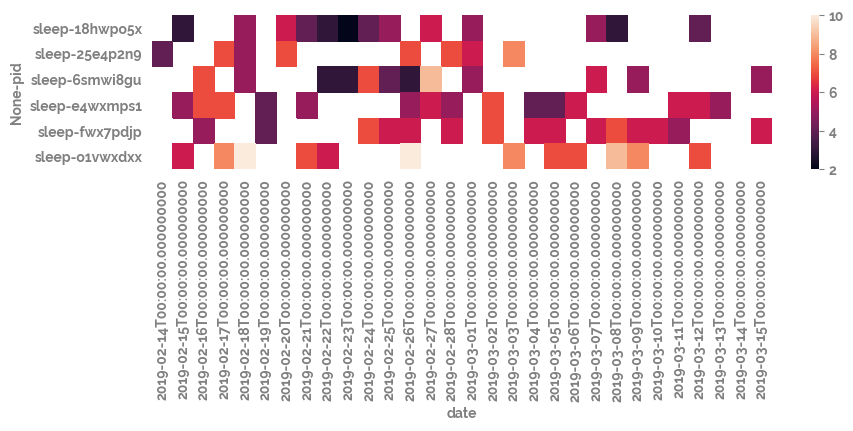

In [19]:
_ = plt.figure(figsize=(10, 2))
_ = sns.heatmap(raw_df_mnar[raw_df_mnar["pid"].isin(user_ids)].set_index(["date"]).pivot(columns="pid").T)

In [20]:
miss_df = raw_df_mnar[raw_df_mnar["pid"].isin(user_ids)].rename(columns={feature: f"{feature}_w_miss"})

In [21]:
miss_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 82 to 5430
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pid           174 non-null    object        
 1   date          174 non-null    datetime64[ns]
 2   sleep_w_miss  75 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.4+ KB


In [22]:
def mice_forest(data, params=None):
    # Create kernel. 
    kds = mf.ImputationKernel(
    data,
    datasets=10,
    save_all_iterations=True,
    random_state=1991
    )

    # Run the MICE algorithm for N amount of iterations
    kds.mice(iterations = 10, variable_parameters=params)

    # Return the completed kernel data
    completed_data = kds.complete_data(dataset=0, inplace=False)

    completed_data = completed_data.set_index(data.index)
    return completed_data

<ipython-input-26-fa51edef1da2>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(tmp_df[f"{feature}_w_miss"].index.astype(str), rotation=90)
<ipython-input-26-fa51edef1da2>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(tmp_df[f"{feature}_w_miss"].index.astype(str), rotation=90)
<ipython-input-26-fa51edef1da2>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(tmp_df[f"{feature}_w_miss"].index.astype(str), rotation=90)
<ipython-input-26-fa51edef1da2>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(tmp_df[f"{feature}_w_miss"].index.astype(str), rotation=90)
<ipython-input-26-fa51edef1da2>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(tmp_df[f"{feature}_w_miss"].index.astype(str), rotation=90)
<ipython-input-26-fa

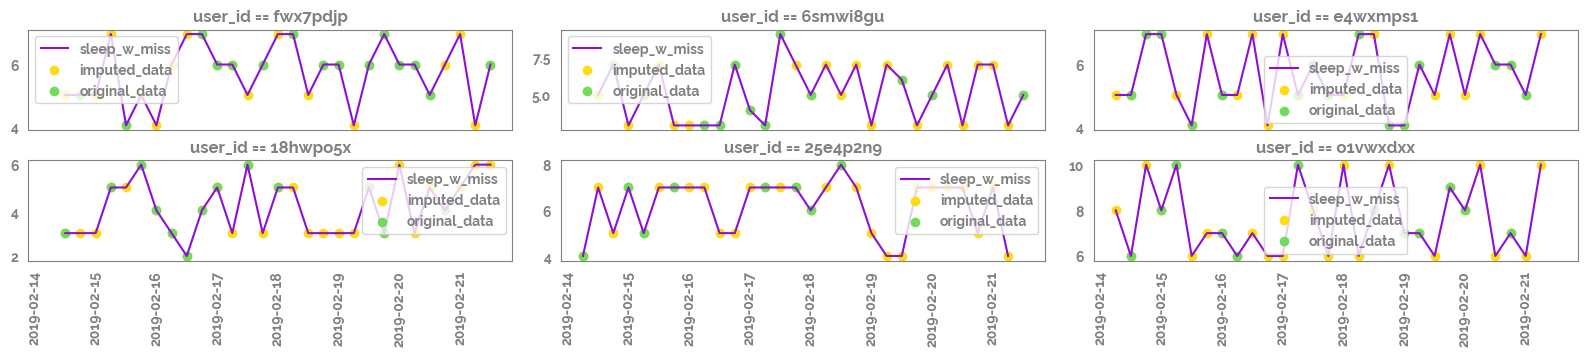

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 3), sharex=True, gridspec_kw={"hspace": 0.3, "wspace":0.1})
for i in range(len(user_ids)):
    user = user_ids[i]
    tmp_df = (miss_df
    .loc[miss_df["pid"]==user, [f"{feature}_w_miss", "date"]]
    .set_index("date")
    )
    
    completed_data = mice_forest(tmp_df)

    ts = completed_data[f"{feature}_w_miss"]
    # _ = plt.figure(figsize=(7, 3))
    ax = axs.flatten()[i]
    _ = ax.plot(ts, label=f"{feature}_w_miss")
    _ = ax.scatter(ts.index, ts.values, c=JmsColors.YELLOW, label="imputed_data")
    _ = ax.scatter(tmp_df[f"{feature}_w_miss"].index, tmp_df[f"{feature}_w_miss"].values, c=JmsColors.GREENYELLOW, label="original_data")
    _ = ax.set_xticklabels(tmp_df[f"{feature}_w_miss"].index.astype(str), rotation=90)
    _ = ax.set_title(f"user_id == {user}")
    _ = ax.legend()

In [32]:
def RMSE(true, pred):
    return np.sqrt(mean_squared_error(y_true=true, y_pred=pred))

In [33]:
def groupby_mice(data, ids):
    return pd.concat([mice_forest(data[data["pid"]==user]
             .drop("pid", axis=1)
             .set_index("date")
             ).assign(**{"pid": user}).reset_index() for user in ids]).set_index(["pid", "date"])

In [35]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer

In [36]:
def simple_impute(data, strategy="mean"):
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    return imp.fit_transform(data.values.reshape(-1,1))

In [38]:
def mice_forest_tune(data):
    # Create kernel. 
    kds = mf.ImputationKernel(
    data,
    datasets=10,
    save_all_iterations=True,
    random_state=1991
    )

    optimal_parameters, losses = kds.tune_parameters(
        dataset=0,
        optimization_steps=5
      )

    return optimal_parameters

In [39]:
mice_forest_tune(data=miss_df.set_index(["pid", "date"]))

{0: {'boosting': 'gbdt',
  'num_iterations': 1,
  'max_depth': 8,
  'num_leaves': 11,
  'min_data_in_leaf': 3,
  'min_sum_hessian_in_leaf': 0.1,
  'min_gain_to_split': 0.0,
  'bagging_fraction': 0.5362710295221387,
  'feature_fraction': 1.0,
  'feature_fraction_bynode': 0.5090275780129762,
  'bagging_freq': 1,
  'verbosity': -1,
  'objective': 'regression',
  'seed': 27423,
  'learning_rate': 0.05,
  'cat_smooth': 3.6664343434715003}}

In [40]:
assign_dict = {feature: df[feature],
               f"{feature}_mean": lambda d: d[f"{feature}_w_miss"].pipe(simple_impute, strategy="mean"),
               f"{feature}_median": lambda d: d[f"{feature}_w_miss"].pipe(simple_impute, strategy="median"),
               f"{feature}_mice_groupby": lambda d: groupby_mice(data=d, ids=d["pid"].unique().tolist())[f"{feature}_w_miss"].values,
                  f"{feature}_mice": lambda d: mice_forest(data=d.set_index(["pid", "date"]))[f"{feature}_w_miss"].values,
                  f"{feature}_linear_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method="linear"),
                  f"{feature}_time_interpolate": lambda d: d.set_index("date")[[f"{feature}_w_miss"]].interpolate(method="time").values,
                  f"{feature}_nearest_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method="nearest"),
                  # f"{feature}_poly_5_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method='polynomial', order=5),
                  f"{feature}_spline_5_interpolate": lambda d: d[f"{feature}_w_miss"].interpolate(method='spline', order=5),
                  }

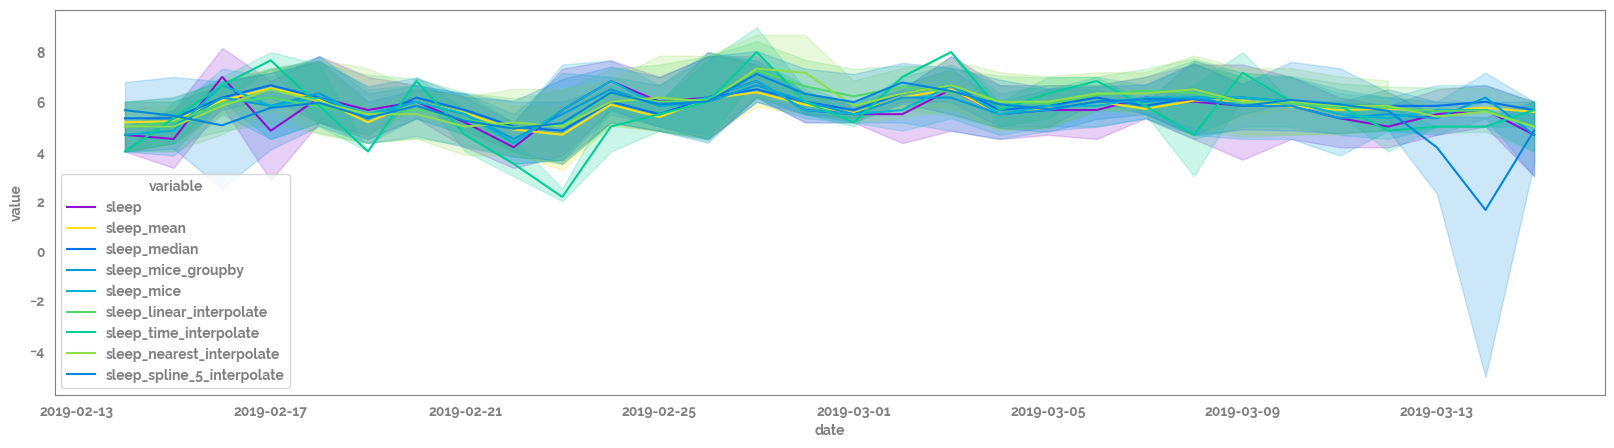

In [41]:
_ = plt.figure(figsize=(20,5))
plot_df = (miss_df
                 .assign(**assign_dict)
                .drop(f"{feature}_w_miss", axis=1)
                 .melt(id_vars = ["pid", "date"]))
_ = sns.lineplot(data=plot_df, x="date", y="value", hue="variable")

In [42]:
comp_df = (miss_df
                .assign(**assign_dict)
                .filter(regex=feature)
                # .pipe(apply_scaling)
                .drop(f"{feature}_w_miss", axis=1)
                .dropna()
                )
rmse_df = pd.concat([pd.DataFrame({f"{feature}": RMSE(comp_df[feature], comp_df[y])}, index=[y]) for y in comp_df.drop(feature, axis=1)])
comp_df.head()

,sleep,sleep_mean,sleep_median,sleep_mice_groupby,sleep_mice,sleep_linear_interpolate,sleep_time_interpolate,sleep_nearest_interpolate,sleep_spline_5_interpolate
82,3.0,3.00,3.0,3.0,3.0,3.000000,3.0,3.0,3.000000
83,7.0,5.76,6.0,5.0,7.0,3.666667,7.0,3.0,-1.290253
84,1.0,5.76,6.0,4.0,4.0,4.333333,8.0,5.0,1.836776
85,5.0,5.00,5.0,5.0,5.0,5.000000,5.0,5.0,5.000000
86,5.0,5.76,6.0,5.0,5.0,5.500000,4.0,5.0,6.358090


In [44]:
colors = [JmsColors.YELLOW, "#F7F1F0", JmsColors.PURPLE]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'heatmap_cmap'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bins)

feat_list = list(assign_dict.keys())
corr_df = correlation_analysis(data=comp_df, col_list=[feat_list[0]], row_list=feat_list[1:], method="spearman")["summary"]
corr_df.style.background_gradient(cmap=cm,
                                  subset="r-value",
                                  vmin=0,
                                  vmax=1,
                                  axis=0).format({'r-value':'{:.4f}', 'p-value':'{:.3f}'})

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,sleep,sleep_mean,0.6172,0.000,True,172
1,Spearman Rank,sleep,sleep_median,0.6342,0.000,True,172
2,Spearman Rank,sleep,sleep_mice_groupby,0.9026,0.000,True,172
3,Spearman Rank,sleep,sleep_mice,0.9861,0.000,True,172
4,Spearman Rank,sleep,sleep_linear_interpolate,0.7509,0.000,True,172
5,Spearman Rank,sleep,sleep_time_interpolate,0.4051,0.000,True,172
6,Spearman Rank,sleep,sleep_nearest_interpolate,0.7212,0.000,True,172
7,Spearman Rank,sleep,sleep_spline_5_interpolate,0.7217,0.000,True,172


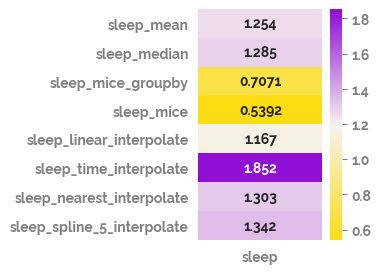

In [47]:
_ = plt.figure(figsize=(2,3))
_ = sns.heatmap(data=rmse_df,
                annot=True,
                fmt=".4g",
                cmap=cm)
_ = plt.yticks(rotation=0)